In [1]:
import os
import wandb

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import ray
from ray.tune.registry import register_env
from ray.rllib.algorithms.ppo import PPO

from gym_env_rlot.buy_sell.gym_env import BuySellUndEnv 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
 

In [2]:
run = wandb.init()
version = "v2"
model_artifact = run.use_artifact(f'jeroencvlier/rlot-PPO-pipeline-v1-noise-nounderlying/iteration_1:{version}', type='model')
data_artifact = run.use_artifact(model_artifact.metadata["data_artifact"], type='data')
model_path = model_artifact.download()
data_path = data_artifact.download()
wandb.finish()


2024-03-03 14:56:46,916 - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jeroencvlier. Use `wandb login --relogin` to force relogin


CommError: Unable to fetch artifact with name jeroencvlier/rlot-PPO-pipeline-v1-noise-nounderlying/iteration_1:v2

In [9]:
ray.shutdown()

In [17]:
def env_creator(env_config):
    return BuySellUndEnv(env_config)

ray.init(ignore_reinit_error=True)
register_env("buysellmulti_env", lambda config: env_creator(config))
algo = PPO.from_checkpoint(os.path.join(model_artifact, "PPO"))


2024-02-21 15:35:45,377	INFO worker.py:1724 -- Started a local Ray instance.


TypeError: expected str, bytes or os.PathLike object, not Artifact

2024-02-21 15:30:41,654 - Loaded data from /Users/jeroenvanlier/Documents/Github/gym-env-rlot/artifacts/percentage_bin_nounderlying:v2
2024-02-21 15:30:41,686 - Dropped 0 rows with NA values
2024-02-21 15:30:41,830 - Loaded data from /Users/jeroenvanlier/Documents/Github/gym-env-rlot/artifacts/percentage_bin_nounderlying:v2
2024-02-21 15:30:41,850 - Dropped 0 rows with NA values


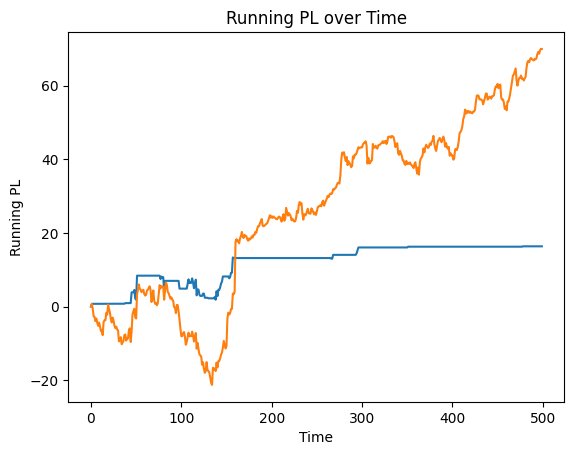

In [ ]:
# Example of using the loaded model for inference
env_bh = env_creator({"artifact_path": data_artifact, "test_train": "test"}) 
env = env_creator({"artifact_path": data_artifact, "test_train": "test"}) 

obs,_ = env_bh.reset()
done = False
while not done:
    obs, reward, done, truncated, info = env_bh.step(action=1)
    

obs,_ = env.reset()
done = False
total_pl = []

while not done:
    action = algo.compute_single_action(obs, explore=False)
    obs, reward, done, truncated, info = env.step(action)    
    


plt.plot(env.running_pl_list)
plt.plot(env_bh.running_pl_list)
plt.xlabel('Time')
plt.ylabel('Running PL')
plt.title('Running PL over Time')
plt.show()



In [7]:
def model_prediction(state_array):
    # Initialize an empty list to store actions
    actions = []
    # Loop through each state in the state_array
    for state in state_array:
        # Compute action for the current state
        # Adjust this line if your compute_single_action method returns something other than a single value
        action = algo.compute_single_action(state, explore=False)
        actions.append(action)
    return np.array(actions)


In [9]:
import shap
obs,_ = env.reset()
state_dimension = len(obs)
initial_states = np.random.uniform(low=-1.0, high=1.0, size=(2, state_dimension))
explainer = shap.DeepExplainer(model_prediction, initial_states)
shap_values = explainer.shap_values(initial_states)
shap.summary_plot(shap_values, 
                  features=env.feature_names, 
                  feature_names=env.feature_names, 
                  max_display=20,
                  plot_type='violin',
                  plot_size=(10, 10))

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


ValueError: <class 'function'> is not currently a supported model type!

In [30]:
import pandas as pd
df = pd.DataFrame({
    "mean_abs_shap": np.mean(np.abs(shap_values), axis=0), 
    "stdev_abs_shap": np.std(np.abs(shap_values), axis=0), 
    "name": features
})
df.sort_values("mean_abs_shap", ascending=False)[:10]

array([ 0.        ,  0.        , -0.00987353, ..., -0.02571182,
       -0.13978368,  0.        ])

In [ ]:
ray.shutdown()